# Topic Modeling on web-pages

Based on the default topic-modeling notebook proposed by dataiku.

Please be carefull: We are playing here with the whole dataset. Vectorizing, for instance, will take several hours.

## Setup and dataset loading <a id="setup" />

**This notebook requires the installation of the [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html#installation) package.**
[See here for help with intalling python packages.](https://www.dataiku.com/learn/guide/code/python/install-python-packages.html)

In [1]:
# to install the required packages. Uncomment the two next lines if necessary
# !pip install --upgrade pip
# !pip install pandas seaborn sklearn pyldavis

%pylab inline
import warnings                         # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
#from dataiku import pandasutils as pdu
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

from sklearn.decomposition import LatentDirichletAllocation,NMF
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from stop_words import get_stop_words

Populating the interactive namespace from numpy and matplotlib


## Let's create the French and English corpora

The following cell will take some time.

In [2]:
# First, we load web-pages.csv as a dataframe
web_pages = pd.read_csv('data/web-pages.csv') # add nrows = 1000 to load only the first 1000 lines.

# We create a mask where the language column = en
web_pages_mask_en = web_pages['language']=='en'
# web_pages_mask_fr = web_pages['language']=='fr'

# We apply this mask to web_pages so that our new dataframe is web_pages_en
web_pages_en = web_pages[web_pages_mask_en]
# web_pages_fr = web_pages[web_pages_mask_fr]


In [3]:
# we delete the web_pages dataframe as we don't need it anymore
del web_pages

In [4]:
#We display our dataframe web_pages_en
web_pages_en

,crawl_date,domain,url,mime_type_web_server,mime_type_tika,language,content
1,20120118,feedburner.com,http://feeds.feedburner.com/QuoteSnack,text/html,text/html,en,"Stop SOPA! If Congress passes SOPA, the Intern..."
2,20120118,thedeadcrows.com,http://thedeadcrows.com/sopa.html,text/html,application/xhtml+xml,en,STOP SOPA! STOP SOPA! STOP SOPA! This site has...
3,20120118,youtube.com,http://www.youtube.com/embed/WU_gZNVfuf0?wmode...,text/html,text/html,en,Life in a Day Soundtrack - Angolan Women - You...
4,20120118,selectivism.com,http://selectivism.com/2010/02/,text/html,application/xhtml+xml,en,2010 February : Selectivism ABOUT TIP-OFF CON...
6,20120118,hackedgadgets.com,http://hackedgadgets.com/2007/02/,text/html,application/xhtml+xml,en,2007 February - Hacked Gadgets – DIY Tech Blo...
...,...,...,...,...,...,...,...
219986,20120118,eff.org,https://www.eff.org/deeplinks/2012/01/sites/al...,text/html,application/xhtml+xml,en,Electronic Frontier Foundation | Defending you...
219987,20120118,eff.org,https://www.eff.org/deeplinks/2012/01/sites/al...,text/html,application/xhtml+xml,en,Electronic Frontier Foundation | Defending you...
219988,20120118,eff.org,https://www.eff.org/deeplinks/2012/01/sites/al...,text/html,application/xhtml+xml,en,Electronic Frontier Foundation | Defending you...
219989,20120118,eff.org,https://www.eff.org/deeplinks/2012/01/0.8,text/html,application/xhtml+xml,en,Electronic Frontier Foundation | Defending you...


## Now, some fun with the english corpus

In [5]:
#we display the columns so that we can choose the right one to process the topic modelling
web_pages_en.columns

Index(['crawl_date', 'domain', 'url', 'mime_type_web_server', 'mime_type_tika',
       'language', 'content'],
      dtype='object')

In [6]:
# We define the column that we will choose for the topic modelling
raw_text_col_en = "content"
# We create the dataframe with the "content" column only
raw_text_en = web_pages_en[raw_text_col_en]
# We remove the NaN to be sure
raw_text_en = raw_text_en.dropna()
# We display the result (to be sure we did what we wanted to do)
raw_text_en

1         Stop SOPA! If Congress passes SOPA, the Intern...
2         STOP SOPA! STOP SOPA! STOP SOPA! This site has...
3         Life in a Day Soundtrack - Angolan Women - You...
4         2010  February : Selectivism ABOUT TIP-OFF CON...
6         2007  February - Hacked Gadgets – DIY Tech Blo...
                                ...                        
219986    Electronic Frontier Foundation | Defending you...
219987    Electronic Frontier Foundation | Defending you...
219988    Electronic Frontier Foundation | Defending you...
219989    Electronic Frontier Foundation | Defending you...
219990    Electronic Frontier Foundation | Defending you...
Name: content, Length: 135484, dtype: object

### Text Processing

We cannot directly feed the text to the Topics Extraction Algorithms. We first need to process the text in order to get numerical vectors. We achieve this by applying either a CountVectorizer() or a TfidfVectorizer(). For more information on those technics, please refer to thid [sklearn documentation](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).   

As with any text mining task, we first need to remove stop words that provide no useful information about topics. *sklearn* provides a default stop words list for english, but we can alway add to it any custom stop words :

In [7]:
# we remove the stopwords

# Uncomment the next line to define custom stopwords
#custom_stop_words = [u'did', u'good', u'right', u'said', u'does', u'way',u'edu', u'com', u'mail', u'thanks', u'post', u'address', u'university', u'email', u'soon', u'article',u'people', u'god', u'don', u'think', u'just', u'like', u'know', u'time', u'believe', u'say',u'don', u'just', u'think', u'probably', u'use', u'like', u'look', u'stuff', u'really', u'make', u'isn']

stop_words_en = text.ENGLISH_STOP_WORDS #.union(custom_stop_words) - add this part if you added custom stop words

#### CountVectorizer() on the text data <a id="tfidf" /> 

We first initialise a CountVectorizer() object and then apply the fit_transform method to the text.

**This will take ages (several hours), be very patient**

In [8]:
cnt_vectorizer_en = CountVectorizer(stop_words = stop_words_en,lowercase = True,
                    token_pattern = r'\b[a-zA-Z]{3,}\b', max_df = 0.85, min_df = 2)

text_cnt_en = cnt_vectorizer_en.fit_transform(raw_text_en)

print(text_cnt_en.shape)

(135484, 209533)


#### TfidfVectorizer() on the text data <a id="tfidf" /> 

We first initialise a TfidfVectorizer() object and then apply the fit_transform method to the text.

**Same: ages, patience**

In [9]:
tfidf_vectorizer_en = TfidfVectorizer(strip_accents = 'unicode',stop_words = stop_words_en,lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b', max_df = 0.75, min_df = 0.02)

text_tfidf_en = tfidf_vectorizer_en.fit_transform(raw_text_en)

print(text_tfidf_en.shape)

(135484, 1114)


In the following, we will apply the topics extraction to `text_tidf`.

### Topics Extraction Models <a id="mod" /> 

There are two very popular models for topic modelling, both available in the sklearn library: 

* [NMF (Non-negative Matrix Factorization)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization),
* [LDA (Latent Dirichlet Allocation)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

Those two topic modeling algorithms infer topics from a collection of texts by viewing each document as a mixture of various topics. The only parameter we need to choose is the number of desired topics `n_topics`.  
It is recommended to try different values for `n_topics` in order to find the most insightful topics. For that, we will show below different analyses (most frequent words per topics and heatmaps).

In [10]:
n_topics = 25

Use this line for LDA

In [11]:
topics_model_en = LatentDirichletAllocation(n_topics, random_state=0)

In [12]:
topics_model_en.fit(text_tfidf_en)

LatentDirichletAllocation(n_components=25, random_state=0)

Using NMF instead.

In [13]:
# topics_model_nmf_en = NMF(n_topics, random_state=0)

In [14]:
#topics_model_nmf.fit(text_tfidf)

#### Most Frequent Words per Topics
An important way to assess the validity of our topic modelling is to directly look at the most frequent words in each topics.

In [15]:
n_top_words = 25
feature_names_en = tfidf_vectorizer_en.get_feature_names()

def get_top_words_topic(topic_idx):
    topic = topics_model_en.components_[topic_idx]
   
    print( [feature_names_en[i] for i in topic.argsort()[:-n_top_words - 1:-1]] )
    
for topic_idx, topic in enumerate(topics_model_en.components_):
    print ("Topic #%d:" % topic_idx )
    get_top_words_topic(topic_idx)
    print ("")

Topic #0:
['abby', 'whitney', 'spamming', 'abbyyy', 'spammerrrrrrrrrr', 'wtg', 'wench', 'lolol', 'wenches', 'rofl', 'heya', 'havent', 'idk', 'msn', 'ugh', 'ing', 'ninja', 'wtf', 'opened', 'decide', 'lol', 'color', 'guest', 'box', 'guess']

Topic #1:
['abby', 'whitney', 'spamming', 'wtg', 'wench', 'abbyyy', 'spammerrrrrrrrrr', 'wenches', 'lolol', 'rofl', 'heya', 'havent', 'idk', 'msn', 'ugh', 'ing', 'ninja', 'wtf', 'opened', 'decide', 'lol', 'color', 'guest', 'box', 'guess']

Topic #2:
['official', 'video', 'subscribe', 'needs', 'twitter', 'archive', 'contact', 'river', 'south', 'choose', 'problem', 'needed', 'western', 'community', 'dark', 'true', 'town', 'videos', 'don', 'advertisement', 'music', 'like', 'year', 'wait', 'hand']

Topic #3:
['best', 'details', 'thursday', 'wrong', 'today', 'january', 'got', 'december', 'price', 'view', 'class', 'free', 'src', 'http', 'thu', 'com', 'color', 'laws', 'quality', 'cool', 'enter', 'source', 'jobs', 'help', 'night']

Topic #4:
['vietnam', 'sai

/Users/frederic.clavert/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Pay attention to the words present, if some are very common you may want to go back to the [definition of custom stop words](#stop_words).





#### Naming the topics

Thanks to the above analysis, we can try to name each topics:

In [16]:
dict_topic_name = {i: "topic_"+str(i) for i in range(n_topics)}
#dict_topic_name = my_dict_topic_name #Define here your own name mapping and uncomment this !

### Topics Heatmaps

Another visual helper to better understand the found topics is to look at the heatmap for the document-topic and topic-words matrices. This gives us the distribution of topics over the collection of documents and the distribution of words over the topics.  
We start with the topic-word heatmap where the darker the color is the more the word is representative of the topic:

<AxesSubplot:xlabel='topic'>

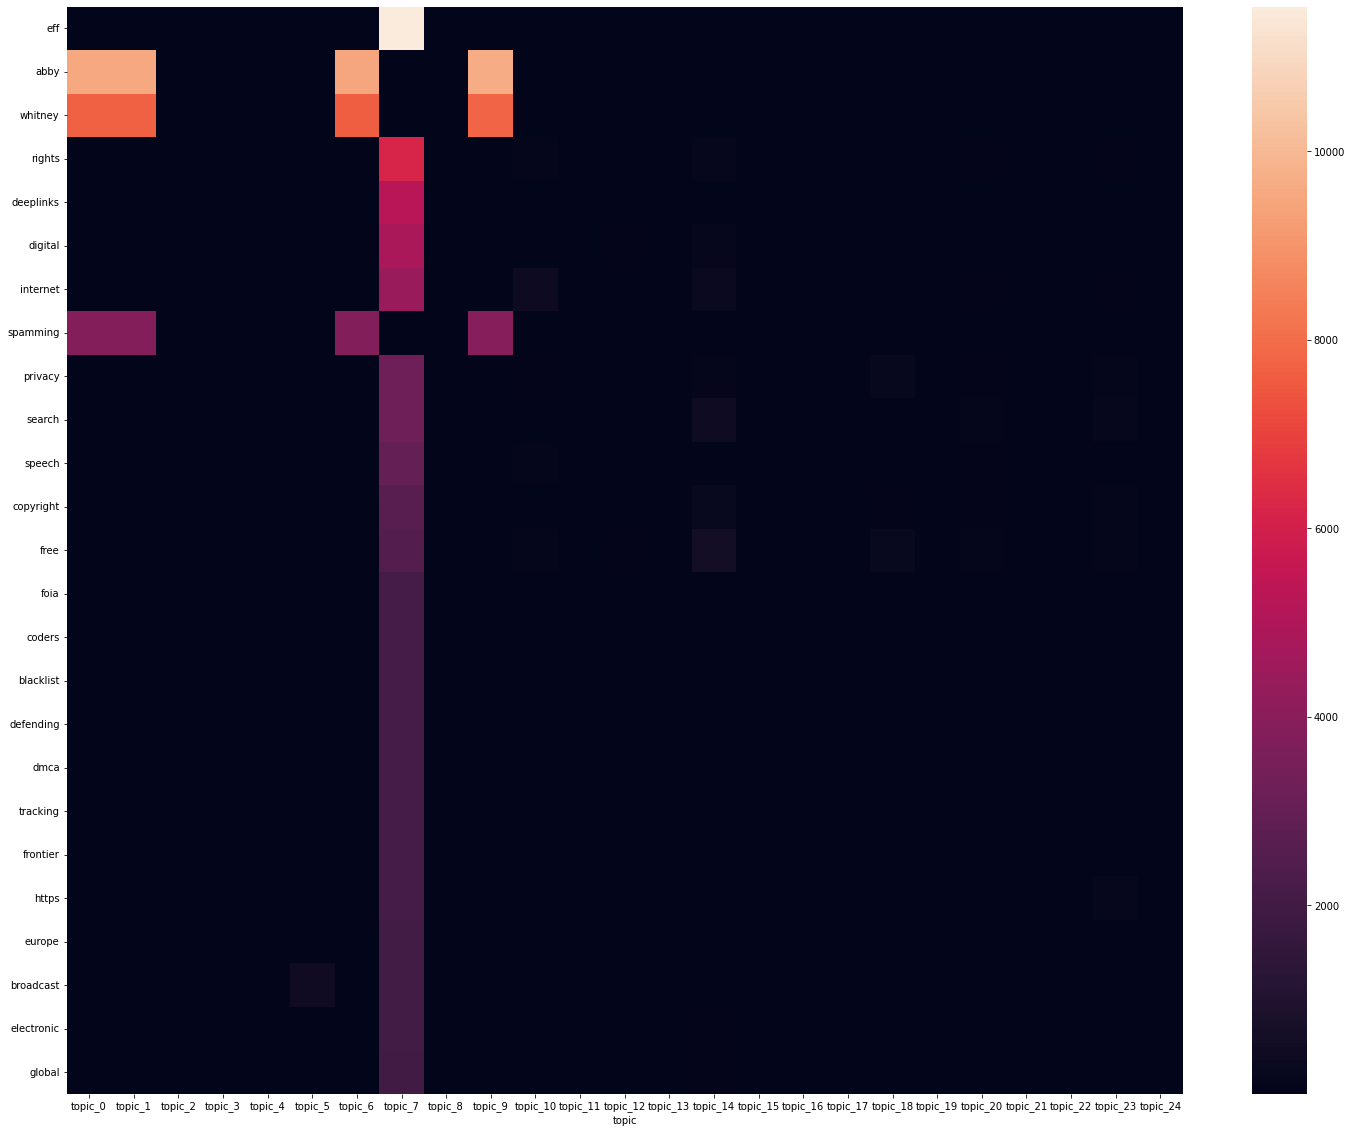

In [17]:
word_model = pd.DataFrame(topics_model_en.components_.T)
word_model.index = feature_names_en
word_model.columns.name = 'topic'
word_model['norm'] = (word_model).apply(lambda x: x.abs().max(),axis=1)
word_model = word_model.sort_values(by='norm',ascending=0) # sort the matrix by the norm of row vector
word_model.rename(columns = dict_topic_name, inplace = True) #naming topic
 
del word_model['norm']

plt.figure(figsize=(25,20))
sns.heatmap(word_model[:25]) 

We now display the document-topic heatmap:

<AxesSubplot:xlabel='topic'>

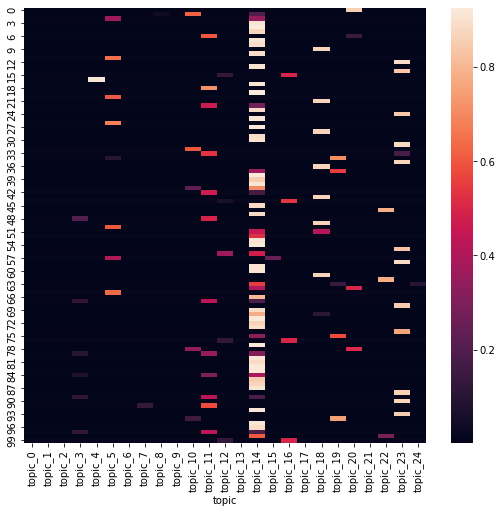

In [18]:
# retrieve the document-topic matrix
document_model = pd.DataFrame(topics_model_en.transform(text_tfidf_en))
document_model.columns.name = 'topic'
document_model.rename(columns = dict_topic_name, inplace = True) #naming topics

plt.figure(figsize=(9,8))
sns.heatmap(document_model.sort_index()[:100]) #we limit here to the first 10 texts

#### Topic distribution over the corpus  
We can look at how the topics are represented in the collection of documents.

<AxesSubplot:xlabel='topic'>

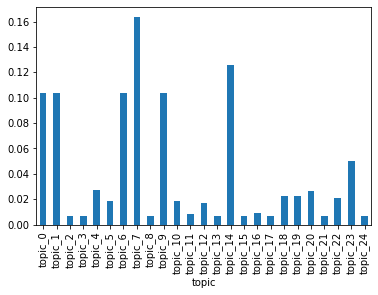

In [19]:
topics_proportion = document_model.sum()/document_model.sum().sum()
topics_proportion.plot(kind = "bar")

For each topic, we can investigate the documents the most representative for the given topic:

In [20]:
def top_documents_topics(topic_name, n_doc = 3, excerpt = True):
    '''This returns the n_doc documents most representative of topic_name'''
    
    document_index = list(document_model[topic_name].sort_values(ascending = False).index)[:n_doc]
    for order, i in enumerate(document_index):
        print ("Text for the {}-th most representative document for topic {}:\n".format(order + 1,topic_name))
        if excerpt:
            raw_text_en[i][:100]
        else:
            raw_text_en[i]
        "\n******\n"

In [21]:
top_documents_topics("topic_0")

Text for the 1-th most representative document for topic topic_0:

Text for the 2-th most representative document for topic topic_0:



KeyError: 58119

### Topics Visualization with pyLDAvis <a id="viz">

Thanks to the pyLDAvis package, we can easily visualise and interpret the topics that has been fit to our corpus of text data.

In [22]:
gensimvis.prepare(topics_model_en, text_tfidf_en, tfidf_vectorizer_en)

/Users/frederic.clavert/opt/anaconda3/envs/awac2/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


AttributeError: 'TfidfVectorizer' object has no attribute 'token2id'

### Topics Clustering  <a id="clust">  

Once we have fitted topics on the text data, we can try to understand how they relate to one another: we achieve this by doing a hierachical clustering on the topics. We propose two methods, the first is based on a correlation table between topics, the second on a contigency table.

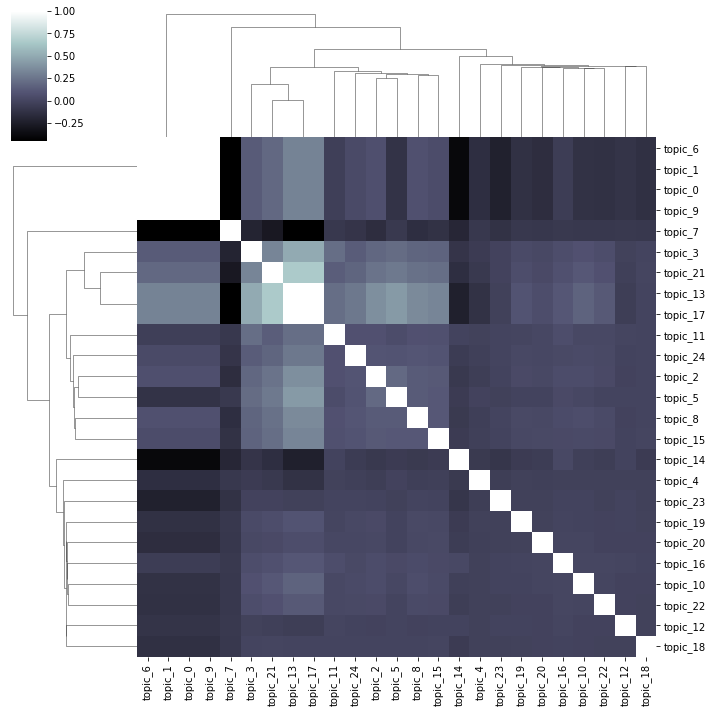

In [23]:
# correlation matrix between topics
cor_matrix = np.corrcoef(document_model.iloc[:,:n_topics].values,rowvar=0)

#Renaming of the index and columns
cor_matrix = pd.DataFrame(cor_matrix)
cor_matrix.rename(index = dict_topic_name, inplace = True)
cor_matrix.rename(columns= dict_topic_name, inplace = True)

sns.clustermap(cor_matrix, cmap="bone")

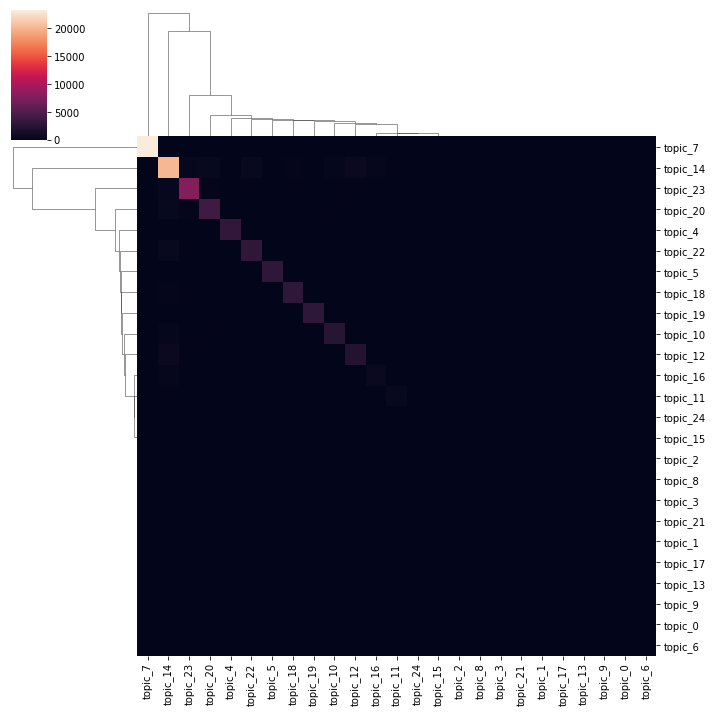

In [24]:
# contingency table on the binarized document-topic matrix
document_bin_topic = (document_model.iloc[:,:n_topics] > 0.25).astype(int)
contingency_matrix = np.dot(document_bin_topic.T.values, document_bin_topic.values )

#Renaming of the index and columns
contingency_matrix = pd.DataFrame(contingency_matrix)
contingency_matrix.rename(index = dict_topic_name, inplace = True)
contingency_matrix.rename(columns= dict_topic_name, inplace = True)

sns.clustermap(contingency_matrix)

### Further steps  <a id="next">  

Topics extraction is a vast subject and a notebook can only show so much. There still much thing we could do, here are some ideas:  


#### Discard documents from noise topics
The following helper function takes as argument the topics for which we wish to discard documents.

In [25]:
def remove_doc(*topic_name):
    
    doc_max_topic = document_model.idxmax(axis = 1)
    "Removing documents whose main topic are in ", topic_name
    doc_max_topic_filtered = doc_max_topic[~doc_max_topic.isin(topic_name)]
    return [raw_text[i] for i in doc_max_topic_filtered.index.tolist()]

#E.g.: to remove documents whose main topic are topic_1 or topic_3, we would simply call remove_doc("topic_0","topic_2")

For the 20newsgroup dataset, try this to remove text of topic "Misc"

In [26]:
#raw_text_filtered = remove_doc("Misc")

#### Scoring the topic model on new text
Finally, we can score new text with our topic model as follows.

<AxesSubplot:>

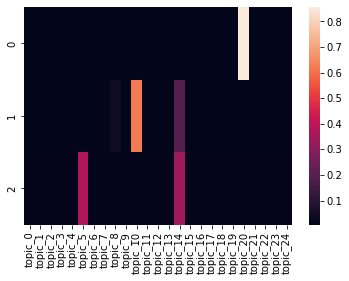

In [27]:
new_text = raw_text_en[:3] #Change this to the new text you'd like to score !

tfidf_new_text_en = tfidf_vectorizer_en.transform(new_text)
result = pd.DataFrame(topics_model_en.transform(tfidf_new_text_en), columns = [dict_topic_name[i] for i in range(n_topics)])
sns.heatmap(result)